In [2]:
import stim
import numpy as np
from numpy.linalg import matrix_power, matrix_rank
import matplotlib.pyplot as plt
from mec import make_circle
import galois
from scipy.sparse import lil_matrix
import os
from ldpc import bposd_decoder
from result import Result, save_new_res, res_to_line
from tqdm import tqdm

In [236]:
# k = 8
code = [12,3,9,1,2,0,1,11,3,12,2,0,11,6]
#code = [9,5,8,4,1,5,8,7,5,9,2,1,9,5]
# code = [12,5,10,4,1,0,1,2,5,12,2,0,11,6]
#code = [15,5,5,2,3,2,7,6,15,5,0,4,11,6]
#code = [30,3,25,3,1,3,22,13,3,30,3,4,11,9]

# k = 12
# code = [14,7,6,5,6,0,4,13,7,14,0,2,12,8]
#code = [18,6,3,4,5,3,7,2,6,18,1,4,16,15]
# code = [12,6,3,1,2,3,1,2,12,6,1,4,16,15]


# k = 16
#code = [15,5,10,3,2,0,9,7,5,15,3,4,16,15]
#code = [30,5,5,3,2,5,3,29,5,30,3,4,17,15]

In [237]:

# 0.001 error rate, all equal error
#muls001=np.array([0,0,1,0,4.29574973,0,3.72796993,0,3.72677149,0,3.89005214,0,3.99232483,0,4.06567307,0,4.50056257,0,4.34609584,0,4.17703894,0,4.67106587,0,4.57802336,0,4.62997696,0,5.65038511,0,5.27687367,0,6.39057363,0,5.62583295,0,6.25768488,0,7.30176588,0,6.79337286,0,7.34345098,0,7.19368032,0,7.85836973,0,8.45210287,0,8.09274835,0,9.94911087,0,10.61948935,0,9.64066608,0,11.52624589,0,11.23228934,0,12.38933908,0,12.30620952,0,13.33238861,0,13.93051327,0,13.33555394,0,14.56815817,0,15.26570976,0,15.89159447,0,15.75822076,0,17.44299357])
#probs=np.array([0,0,1,0,0.98935,0,0.98445,0,0.9794,0,0.97428,0,0.96936,0,0.96417,0,0.95988,0,0.95488,0,0.94804,0,0.94411,0,0.93927,0,0.93305,0,0.93091,0,0.92479,0,0.92167,0,0.91542,0,0.91088,0,0.90663,0,0.90235,0,0.89876,0,0.89245,0,0.89077,0,0.88617,0,0.8798,0,0.87445,0,0.87104,0,0.86716,0,0.86585,0,0.85824,0,0.85396,0,0.85079,0,0.84681,0,0.84419,0,0.84061,0,0.83607,0,0.83324,0,0.82874,0,0.82687,0,0.82096])

# 0.001 error rate, everything other than CNOT and measurement is 10x less
muls001 = np.array([0,0,1,0,2.83437563,0,2.71543645,0,2.66390109,0,2.47514626,0,2.63554603,0,2.8225308,0,3.20738319,0,3.05384743,0,3.01289603,0,3.30535152,0,3.46853617,0,3.30472058,0,3.34178504,0,3.69494846,0,3.74955935,0,3.89150943,0,4.29804057,0,4.622713,0,4.64298887,0,4.83355337,0,4.63747826,0,5.44062479,0,5.48444052,0,6.05625242,0,5.75421291,0,6.06743327,0,6.63790984,0,6.33608196,0,7.24417597,0,6.69331914,0,7.44078094,0,7.59173345,0,8.37524776,0,8.38899217,0,8.80930114,0,9.80709627,0,8.87491589,0,9.62782511,0,9.85953381])
probs = np.array([0,0,1,0,0.9914,0,0.98695,0,0.98352,0,0.97772,0,0.97513,0,0.97076,0,0.96652,0,0.96272,0,0.95921,0,0.953,0,0.95141,0,0.94713,0,0.94261,0,0.93912,0,0.93611,0,0.9328,0,0.92833,0,0.9237,0,0.92182,0,0.91651,0,0.91429,0,0.91166,0,0.9062,0,0.90485,0,0.90021,0,0.89659,0,0.89486,0,0.89014,0,0.88899,0,0.88297,0,0.87894,0,0.87727,0,0.87281,0,0.87138,0,0.86613,0,0.86468,0,0.86198,0,0.85793,0,0.85501])
idle_error = 0.0002

def cyclic_shift_matrix(l):
    arr = np.eye(l, dtype=int)
    return np.roll(arr, axis=1, shift=1)

ell = code[0]
m = code[1]

x = np.kron(cyclic_shift_matrix(ell), np.eye(m))
y = np.kron(np.eye(ell), cyclic_shift_matrix(m))

A1 = matrix_power(x, code[2])
A2 = matrix_power(y, code[3])
A3 = matrix_power(y, code[4])
A = ( A1 + A2 + A3 ) % 2

B1 = matrix_power(y, code[5])
B2 = matrix_power(x, code[6])
B3 = matrix_power(x, code[7])
B = ( B1 + B2 + B3 ) % 2

Hx = np.hstack([A, B]).astype(int)
Hz = np.hstack([B.T, A.T]).astype(int)

GF = galois.GF(2)
arr = GF(Hz.T)
k = 2 * (Hz.T.shape[1] - matrix_rank(arr))


def par2gen(H):
    GF = galois.GF(2)
    gfH = GF(H)
    gfH_rank = np.linalg.matrix_rank(gfH)

    rref_H = gfH.row_reduce()

    swaps = []
    col_H = rref_H.copy()
    for i in range(gfH_rank):
        inds = np.where(col_H[i])[0]
        pivot = inds[0]
        col_H[:,[i,pivot]] = col_H[:,[pivot,i]]
        swaps.append((i,pivot))

    col_H = col_H[:gfH_rank]
    col_G = GF(np.hstack([col_H[:,gfH_rank:].T, np.eye(H.shape[1]-gfH_rank, dtype=int)]))

    G = col_G.copy()
    for swap in swaps[::-1]:
        G[:,[swap[1],swap[0]]] = G[:,[swap[0],swap[1]]]

    if (np.any(G @ rref_H[:gfH_rank].T) or np.any(col_G @ col_H.T)):
        print("FAILED")
        return
    return (np.array(G, dtype=int), np.array(col_G, dtype=int))

def commute(x, z, n):
    # 0 if commute, 1 if anticommute
    x1 = x[:n]
    x2 = x[n:]
    z1 = z[:n]
    z2 = z[n:]
    return (x1 @ z2 % 2) ^ (x2 @ z1 % 2)

def SGSOP(Gx, Gz, n):
    # symplectic gram-schmidt orthogonalization procedure
    sym_Gx = np.hstack([Gx, np.zeros(Gx.shape, dtype=int)])
    sym_Gz = np.hstack([np.zeros(Gz.shape, dtype=int), Gz])
    sym_G = np.vstack([sym_Gx, sym_Gz])
    logicals = []
    generators = []

    while(sym_G.shape[0]):
        g1 = sym_G[0]

        commutes = True
        for i in range(1, sym_G.shape[0]-1):
            g2 = sym_G[i]
            if (commute(g1,g2,n)):
                logicals.append((g1, g2))
                sym_G = np.delete(sym_G, [0, i], axis=0)

                for j in range(sym_G.shape[0]):
                    gj = sym_G[j]
                    sym_G[j] = gj ^ (commute(gj,g2,n) * g1) ^ (commute(gj,g1,n) * g2)
                commutes = False
                break

        if commutes:
            generators.append(g1)
            sym_G = np.delete(sym_G, 0, axis=0)

    return (logicals, generators)

def get_logicals(gen_type=False):
    n = Hx.shape[1]
    Gx, col_Gx = par2gen(Hx)
    Gz, col_Gz = par2gen(Hz)
    logicals, generators = SGSOP(Gx, Gz, n)

    logX = np.array([l[1][n:] for l in logicals])
    logZ = np.array([l[0][:n] for l in logicals])

    if gen_type: return logX
    else: return logZ

def manhattan(qbts):
    p, q = qbts
    return np.abs(p[0]-q[0])+np.abs(p[1]-q[1])

def embed_code(code, init):
    emb_m, emb_ell, A_ind, B_ind = code

    lattice = np.empty((2*emb_m, 2*emb_ell), dtype=object)
    lattice[0][0] = f"x{init}"

    # As = [[A1, A2.T], [A2, A3.T], [A1, A3.T]]
    # Bs = [[B1, B2.T], [B2, B3.T], [B1, B3.T]]
    As = [[A1, A2.T], [A2, A1.T], [A2, A3.T], [A3, A2.T], [A1, A3.T], [A3, A1.T]]
    Bs = [[B1, B2.T], [B2, B1.T], [B2, B3.T], [B3, B2.T], [B1, B3.T], [B3, B1.T]]

    def get_nbr(i, j):
        if (i % 2 == 0):
            if (j % 2 == 0):
                return "x"
            else:
                return "r"
        else:
            if (j % 2 == 0):
                return "l"
            else:
                return "z"

    for i in range(2*emb_m - 1):
        for j in range(2*emb_ell):
            curr_ind = int(lattice[i][j][1:])

            if (i % 2 == 0):
                tmp_A = As[A_ind][1]
            else:
                tmp_A = As[A_ind][0]
            if (j % 2 == 0):
                tmp_B = Bs[B_ind][1]
            else:
                tmp_B = Bs[B_ind][0]

            lattice[(i+1)%(2*emb_m)][j] = f"{get_nbr((i+1)%(2*emb_m), j)}{np.where(tmp_A @ np.eye(m*ell)[curr_ind])[0][0]}"
            lattice[i][(j+1)%(2*emb_ell)] = f"{get_nbr(i, (j+1)%(2*emb_ell))}{np.where(tmp_B @ np.eye(m*ell)[curr_ind])[0][0]}"

    for i in range(2*emb_m):
        for j in range(2*emb_ell):
            if (lattice[i][j][0] == "z"):
                lattice[i][j] = f"z{int(lattice[i][j][1:]) + m*ell}"
            elif (lattice[i][j][0] == "r"):
                lattice[i][j] = f"r{int(lattice[i][j][1:]) + m*ell}"

    return lattice


In [238]:

lattice = embed_code((code[8],code[9],code[10],code[11]), 0)

all_qbts = {}

qbts = np.array([None for i in range(2*m*ell)])
for i in range(lattice.shape[0]):
    for j in range(lattice.shape[1]):
        if lattice[i][j][0] == "r" or lattice[i][j][0] == "l":
            all_qbts[(i,j)] = int(lattice[i][j][1:])
            qbts[int(lattice[i][j][1:])] = (i, j)
x_checks = np.array([None for i in range(m*ell)])
z_checks = np.array([None for i in range(m*ell)])

for i in range(lattice.shape[0]):
    for j in range(lattice.shape[1]):
        if lattice[i][j][0] == "x":
            all_qbts[(i,j)] = int(lattice[i][j][1:]) + 2*m*ell
            x_checks[int(lattice[i][j][1:])] = (i, j)
        elif lattice[i][j][0] == "z":
            all_qbts[(i,j)] = int(lattice[i][j][1:]) + 2*m*ell
            z_checks[int(lattice[i][j][1:])-(m*ell)] = (i, j)

x_rs = []
z_rs = []
for i in range(m*ell):
    gen_qbts = qbts[np.where(Hx[i])[0]]
    x_rs.append(make_circle(gen_qbts)[2])
for i in range(m*ell):
    gen_qbts = qbts[np.where(Hz[i])[0]]
    z_rs.append(make_circle(gen_qbts)[2])

lr_x_checks = np.array([], dtype=int)
sr_x_checks = np.array([], dtype=int)
lr_z_checks = np.array([], dtype=int)
sr_z_checks = np.array([], dtype=int)

z_check_succ_probs = np.ones(m*ell)
x_check_succ_probs = np.ones(m*ell)

for i, x_check in enumerate(x_checks):
    gen_qbts = qbts[np.where(Hx[i])[0]]

    nonlocal_qbts = []
    if (x_rs[i] > (min(x_rs)+np.std(x_rs))):
        lr_x_checks = np.append(lr_x_checks, i)
    else:
        sr_x_checks = np.append(sr_x_checks, i)

    for qbt in gen_qbts:
        x_check_succ_probs[i] *= probs[manhattan([x_check, qbt])+1]

for i, z_check in enumerate(z_checks):
    gen_qbts = qbts[np.where(Hz[i])[0]]

    nonlocal_qbts = []
    if (z_rs[i] > min(z_rs)+np.std(z_rs)):
        lr_z_checks = np.append(lr_z_checks, i)
    else:
        sr_z_checks = np.append(sr_z_checks, i)

    for qbt in gen_qbts:
        z_check_succ_probs[i] *= probs[manhattan([z_check, qbt])+1]

adv = sum(np.array(x_rs)[lr_x_checks]) / sum(x_rs)


In [239]:
def measure_x_checks(checks, p, scale=False):
    c = stim.Circuit()
    c.append("H", [all_qbts[x_checks[x_check]] for x_check in checks])
    c.append("DEPOLARIZE1", [all_qbts[x_checks[x_check]] for x_check in checks], p/10)
    for x in checks:
        gen_qbts = qbts[np.where(Hx[x])[0]]
        for qbt in gen_qbts:
            path_qbts = [all_qbts[x_checks[x]], all_qbts[qbt]]
            c.append("CNOT", path_qbts)
            if scale:
                c.append("DEPOLARIZE2", path_qbts, p*muls001[manhattan([x_checks[x], qbt])+1])
            else:
                c.append("DEPOLARIZE2", path_qbts, p)
    c.append("H", [all_qbts[x_checks[x_check]] for x_check in checks])
    c.append("DEPOLARIZE1", [all_qbts[x_checks[x_check]] for x_check in checks], p/10)
    return c

def measure_z_checks(checks, p, scale=False):
    c = stim.Circuit()
    for z in checks:
        gen_qbts = qbts[np.where(Hz[z])[0]]
        for qbt in gen_qbts:
            path_qbts = [all_qbts[qbt], all_qbts[z_checks[z]]]
            c.append("CNOT", path_qbts)
            if scale:
                c.append("DEPOLARIZE2", path_qbts, p*muls001[manhattan([qbt, z_checks[z]])+1])
            else:
                c.append("DEPOLARIZE2", path_qbts, p)
    return c

def all_checks():
    c = stim.Circuit()
    c += measure_z_checks(sr_z_checks, 0, scale=False)
    c += measure_z_checks(lr_z_checks, 0, scale=False)
    c += measure_x_checks(sr_x_checks, 0, scale=False)
    c += measure_x_checks(lr_x_checks, 0, scale=False)
    return c


class Simulation:
    def __init__(self, num_rounds, lr_time):
        self.num_rounds = num_rounds
        self.lr_time = lr_time

        self.prev_meas_z = np.arange(1, m*ell+1, dtype=int)
        self.prev_meas_x = np.arange(m*ell+1, 2*m*ell+1,  dtype=int)
        self.curr_meas_z = np.zeros(m*ell, dtype=int)
        self.curr_meas_x = np.zeros(m*ell, dtype=int)

        self.route_confirmation_z = np.ones(m*ell, dtype=int)
        self.route_confirmation_z[lr_z_checks] = 0
        self.route_confirmation_x = np.ones(m*ell, dtype=int)
        self.route_confirmation_x[lr_x_checks] = 0
        self.detector_history = np.zeros(m*ell)

        self.c = stim.Circuit()
        for key, value in all_qbts.items():
            self.c.append("QUBIT_COORDS", value, (key[0],key[1],0))
            self.c.append("QUBIT_COORDS", value+(4*m*ell), (key[0],key[1],1))
        self.c.append("R", [qbt for qbt in all_qbts.values()])
        self.c.append("R", [qbt+(4*m*ell) for qbt in all_qbts.values()])

        self.c += all_checks().without_noise()
        self.c.append("MR", [all_qbts[z_check] for z_check in z_checks])
        self.c.append("MR", [all_qbts[x_check] for x_check in x_checks])

    def detectors(self, type):
        num_meas = self.c.num_measurements
        if not type:
            for i, z_check in enumerate(self.curr_meas_z):
                coord = z_checks[i]
                if z_check:
                    self.c.append("DETECTOR", [stim.target_rec(self.curr_meas_z[i]-num_meas-1), stim.target_rec(self.prev_meas_z[i]-num_meas-1)], (coord[0], coord[1], 0))
                    self.prev_meas_z[i] = self.curr_meas_z[i]
                    self.curr_meas_z[i] = 0
        else:
            pass # x type checks

    def observables(self, type):
        for i, logical in enumerate(get_logicals(type)):
            incl_qbts = np.where(logical)[0]
            incl_qbts = [-j-1 for j in incl_qbts]
            self.c.append("OBSERVABLE_INCLUDE", [stim.target_rec(j) for j in incl_qbts], i)

    def sr_round(self, with_gate_noise=True, with_synd_noise=True):
        curr_sr_z_checks = sr_z_checks[self.route_confirmation_z[sr_z_checks]==1]
        curr_sr_x_checks = sr_x_checks[self.route_confirmation_x[sr_x_checks]==1]
        self.c += measure_z_checks(curr_sr_z_checks, 0.001 if with_gate_noise else 0, scale=False)
        self.c += measure_x_checks(curr_sr_x_checks, 0.001 if with_gate_noise else 0, scale=False)

        if with_synd_noise: self.c.append("X_ERROR", [all_qbts[z_checks[z_check]] for z_check in curr_sr_z_checks], 0.001)
        if with_synd_noise: self.c.append("X_ERROR", [all_qbts[x_checks[x_check]] for x_check in curr_sr_x_checks], 0.001)

        for i, z_check in enumerate(curr_sr_z_checks):
            self.c.append("M", all_qbts[z_checks[z_check]])
            self.curr_meas_z[z_check] = self.c.num_measurements
        for i, z_check in enumerate(sr_z_checks):
            self.c.append("R", all_qbts[z_checks[z_check]])
        for i, x_check in enumerate(curr_sr_x_checks):
            self.c.append("M", all_qbts[x_checks[x_check]])
            self.curr_meas_x[x_check] = self.c.num_measurements
        for i, x_check in enumerate(sr_x_checks):
            self.c.append("R", all_qbts[x_checks[x_check]])

        if with_synd_noise: self.c.append("X_ERROR", [all_qbts[z_checks[z_check]] for z_check in sr_z_checks], 0.001/10)
        if with_synd_noise: self.c.append("X_ERROR", [all_qbts[x_checks[x_check]] for x_check in sr_x_checks], 0.001/10)


    def lr_round(self, with_gate_noise=True, with_synd_noise=True):
        curr_sr_z_checks = sr_z_checks[self.route_confirmation_z[sr_z_checks]==1]
        curr_sr_x_checks = sr_x_checks[self.route_confirmation_x[sr_x_checks]==1]
        curr_lr_z_checks = lr_z_checks[self.route_confirmation_z[lr_z_checks]==1]
        curr_lr_x_checks = lr_x_checks[self.route_confirmation_x[lr_x_checks]==1]

        curr_z_checks = np.concatenate([curr_sr_z_checks, curr_lr_z_checks])
        curr_x_checks = np.concatenate([curr_sr_x_checks, curr_lr_x_checks])
        all_z_checks = np.concatenate([sr_z_checks, lr_z_checks])
        all_x_checks = np.concatenate([sr_x_checks, lr_x_checks])

        self.c += measure_z_checks(curr_z_checks, 0.001 if with_gate_noise else 0, scale=False)
        self.c += measure_x_checks(curr_x_checks, 0.001 if with_gate_noise else 0, scale=False)

        if with_synd_noise: self.c.append("X_ERROR", [all_qbts[z_checks[z_check]] for z_check in curr_z_checks], 0.001)
        if with_synd_noise: self.c.append("X_ERROR", [all_qbts[x_checks[x_check]] for x_check in curr_x_checks], 0.001)

        for i, z_check in enumerate(curr_z_checks):
            self.c.append("M", all_qbts[z_checks[z_check]])
            self.curr_meas_z[z_check] = self.c.num_measurements
        for i, z_check in enumerate(all_z_checks):
            self.c.append("R", all_qbts[z_checks[z_check]])
        for i, x_check in enumerate(curr_x_checks):
            self.c.append("M", all_qbts[x_checks[x_check]])
            self.curr_meas_x[x_check] = self.c.num_measurements
        for i, x_check in enumerate(all_x_checks):
            self.c.append("R", all_qbts[x_checks[x_check]])

        if with_synd_noise: self.c.append("X_ERROR", [all_qbts[z_checks[z_check]] for z_check in all_z_checks], 0.001/10)
        if with_synd_noise: self.c.append("X_ERROR", [all_qbts[x_checks[x_check]] for x_check in all_x_checks], 0.001/10)


    def simulate(self):
        for i in range(1,self.num_rounds+1):
            self.c.append("SHIFT_COORDS", [], (0,0,1))
            if (i%self.lr_time==0):
                self.c.append("DEPOLARIZE1", [all_qbts[qbt] for qbt in qbts], 0.001) #+2*(code[12]+code[13])*idle_error)

                # self.route_confirmation_z[sr_z_checks] = [1 if np.random.random() < z_check_succ_probs[z] else 0 for z in sr_z_checks]
                # self.route_confirmation_z[lr_z_checks] = [1 if np.random.random() < z_check_succ_probs[z] else 0 for z in lr_z_checks]
                # self.route_confirmation_x[sr_x_checks] = [1 if np.random.random() < x_check_succ_probs[x] else 0 for x in sr_x_checks]
                # self.route_confirmation_x[lr_x_checks] = [1 if np.random.random() < x_check_succ_probs[x] else 0 for x in lr_x_checks]
                self.route_confirmation_z[sr_z_checks] = 1
                self.route_confirmation_z[lr_z_checks] = 1
                self.route_confirmation_x[sr_x_checks] = 1
                self.route_confirmation_x[lr_x_checks] = 1
                self.detector_history = np.vstack([self.detector_history, self.route_confirmation_z])
                self.lr_round()
            else:
                self.c.append("DEPOLARIZE1", [all_qbts[qbt] for qbt in qbts], 0.001) #+2*code[12]*idle_error)
                # self.route_confirmation_z[sr_z_checks] = [1 if np.random.random() < z_check_succ_probs[z] else 0 for z in sr_z_checks]
                # self.route_confirmation_x[sr_x_checks] = [1 if np.random.random() < x_check_succ_probs[x] else 0 for x in sr_x_checks]
                self.route_confirmation_z[sr_z_checks] = 1
                self.route_confirmation_z[lr_z_checks] = 0
                self.route_confirmation_x[sr_x_checks] = 1
                self.route_confirmation_x[lr_x_checks] = 0
                self.detector_history = np.vstack([self.detector_history, self.route_confirmation_z])
                self.sr_round()
            self.detectors(False)

        # self.route_confirmation_z = np.ones(m*ell)
        # self.route_confirmation_x = np.ones(m*ell)
        # self.detector_history = np.vstack([self.detector_history, self.route_confirmation_z])
        # self.lr_round(with_gate_noise=False, with_synd_noise=False)
        # self.detectors(False)

        self.c.append("M",[all_qbts[qbt] for qbt in qbts[::-1]])
        self.observables(False)

In [456]:
s = Simulation(50, 1)
s.simulate()
c = s.c

In [457]:
detector_sampler = c.compile_detector_sampler()
one_sample = detector_sampler.sample(shots=1, append_observables=True)[0]

ind = 0
last = 0

print("round\tnum\t")
for i in range(1,s.num_rounds+1+last):
    curr_checks = s.detector_history[i]
    num_checks = np.count_nonzero(curr_checks)
    timeslice = one_sample[ind:ind+num_checks]
    j = 0
    print(f"{i}\t{num_checks}\t", end="")
    for check in curr_checks:
        if check:
            if timeslice[j]: print("!", end="")
            else: print("_", end="")
            j += 1
        else: print(" ", end="")
    ind += num_checks
    print()
print()
print("observables\t", end="")
timeslice = one_sample[-k:]
print("".join("!" if e else "_" for e in timeslice))

round	num	
1	36	____________________________________
2	36	________________!__!__!_!_!!_!!_!___
3	36	_______!!________________________!__
4	36	____________________________________
5	36	____________________________________
6	36	____________________________________
7	36	____________________________________
8	36	_______________________!______!!__!_
9	36	_!__!_______________________________
10	36	____________________________________
11	36	___________!______!!________________
12	36	_____________________!__!______!!_!!
13	36	____________________________________
14	36	________!!__!___!__!!_!!_!!_________
15	36	____________________________________
16	36	____________________________________
17	36	________________!___________________
18	36	__________!__!____________________!_
19	36	__________________________________!_
20	36	___!__!__!__________________________
21	36	!__!__!_____________________________
22	36	____________________________________
23	36	____________________________________
24	36	___

In [458]:
sampler = c.compile_detector_sampler()
dem = c.detector_error_model()
pcm = lil_matrix((dem.num_detectors, dem.num_errors), dtype=np.bool_)
lcm = lil_matrix((dem.num_observables, dem.num_errors), dtype=np.bool_)

errors = []
channel_probs = [e.args_copy()[0] for e in dem if e.type=="error"]
for i, error_event in enumerate(c.explain_detector_error_model_errors()):
    dets = [det.dem_target.val for det in error_event.dem_error_terms if det.dem_target.is_relative_detector_id()]
    obs = [ob.dem_target.val for ob in error_event.dem_error_terms if ob.dem_target.is_logical_observable_id()]
    pcm[[dets],i] = 1
    lcm[[obs],i] = 1

print(pcm.shape)
print(lcm.shape)

(1800, 17732)
(8, 17732)


In [464]:
bposd_dec = bposd_decoder(
    pcm, # the parity check matrix
    channel_probs=channel_probs, #assign error_rate to each qubit. This will override "error_rate" input variable
    max_iter=pcm.shape[1], #the maximum number of iterations for BP)
    bp_method="ms",
    ms_scaling_factor=0, #min sum scaling factor. If set to zero the variable scaling factor method is used
    osd_method="osd_cs", #the OSD method. Choose from:  1) "osd_e", "osd_cs", "osd0"
    osd_order=min(pcm.shape[0],10) #the osd search depth
)


detection_events, observable_flips = sampler.sample(1, separate_observables=True)
guessed_errors = bposd_dec.decode(detection_events[0])
guessed_obs = (lcm @ guessed_errors) % 2
success = np.all(observable_flips[0].astype(int) == guessed_obs)
print(success, np.where(guessed_errors))

True (array([  100,   110,   477,  1141,  1672,  2127,  3997,  4134,  5201,
        6260,  7324,  8032,  8175, 10221, 10693, 11578, 11596, 12004,
       13477, 14039, 14974, 15938, 17156], dtype=int64),)


In [479]:
window_size = 5
start_det = 11

start_error = max(pcm[(start_det-1)*m*ell:start_det*m*ell].nonzero()[1]) if start_det else 0
next_start_error = max(pcm[start_det*m*ell:(start_det+1)*m*ell].nonzero()[1])
end_error = max(pcm[start_det*m*ell:(start_det+window_size)*m*ell].nonzero()[1])
window_pcm = pcm[start_det*m*ell:(start_det+window_size)*m*ell][:,start_error:end_error]
# print(pcm[start_det*m*ell:(start_det+window_size)*m*ell][:,start_error:end_error].shape)
print(start_error, next_start_error, end_error)

synd = detection_events[0].astype(np.bool_)
corrected_error = np.zeros(dem.num_errors, dtype=np.bool_)
corrected_error[100] = 1
corrected_error[110] = 1
corrected_error[447] = 1
corrected_error[1141] = 1
corrected_error[1672] = 1
corrected_error[2127] = 1

synd ^= (pcm @ corrected_error).astype(np.bool_)

bposd_dec_partial = bposd_decoder(
    window_pcm,
    channel_probs=channel_probs[start_error:end_error], #assign error_rate to each qubit. This will override "error_rate" input variable
    max_iter=pcm.shape[1], #the maximum number of iterations for BP)
    bp_method="ms",
    ms_scaling_factor=0, #min sum scaling factor. If set to zero the variable scaling factor method is used
    osd_method="osd_cs", #the OSD method. Choose from:  1) "osd_e", "osd_cs", "osd0"
    osd_order=min(pcm.shape[0],10) #the osd search depth
)

ge = bposd_dec_partial.decode(synd[start_det*m*ell:(start_det+window_size)*m*ell])
print([e + start_error for e in np.where(ge)])

3821 4178 5606
[array([3997, 4134, 5201], dtype=int64)]


In [ ]:
def decode_window(window_size):
    pass

In [450]:
corrected_error = np.zeros(dem.num_errors)
corrected_error[191] = 1

(pcm @ corrected_error).astype(np.bool_) ^ synd

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [432]:
synd.astype(int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

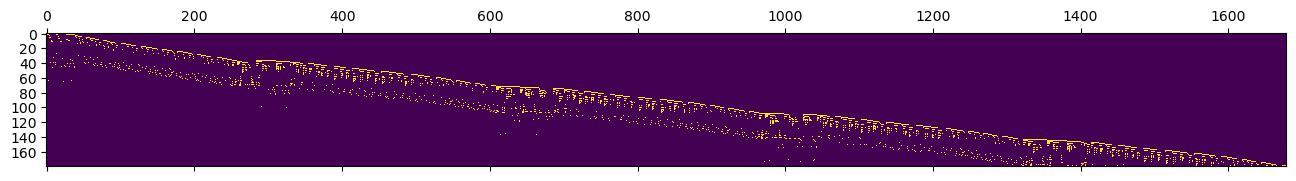

In [433]:
plt.matshow(window_pcm.A)

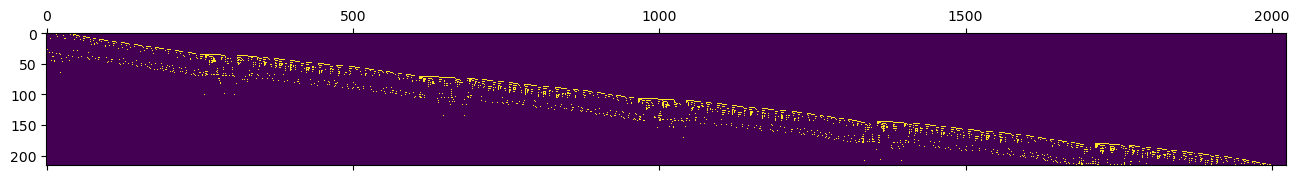

In [392]:
plt.matshow(pcm.A)

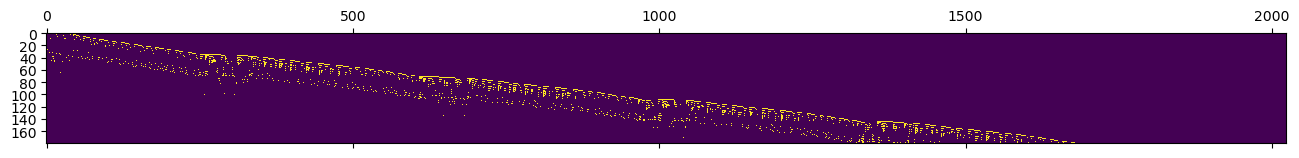

In [396]:
plt.matshow(pcm[start_det*m*ell:(start_det+window_size)*m*ell].A)

(144, 1310) (8, 1310) 1285
(180, 1667) (8, 1667) 1322
(216, 2024) (8, 2024) 1322
(252, 2381) (8, 2381) 1322
(288, 2738) (8, 2738) 1322


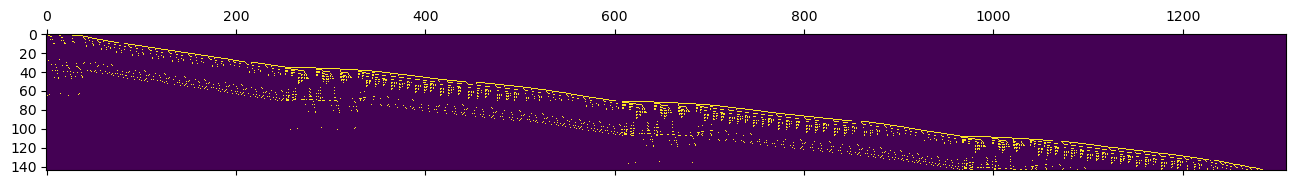

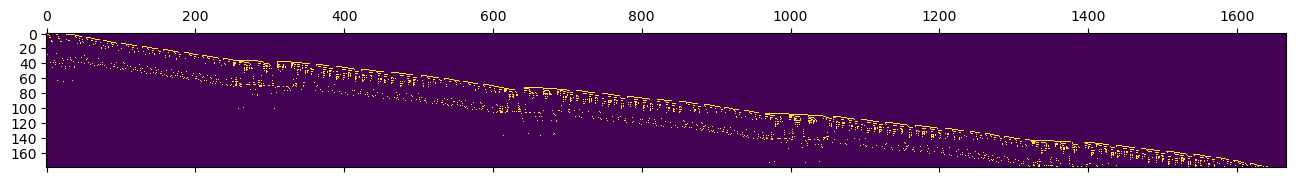

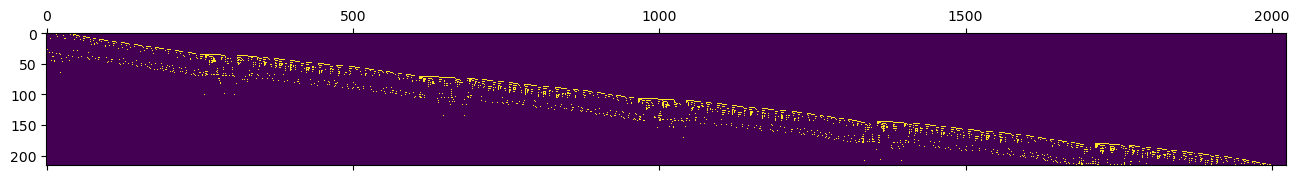

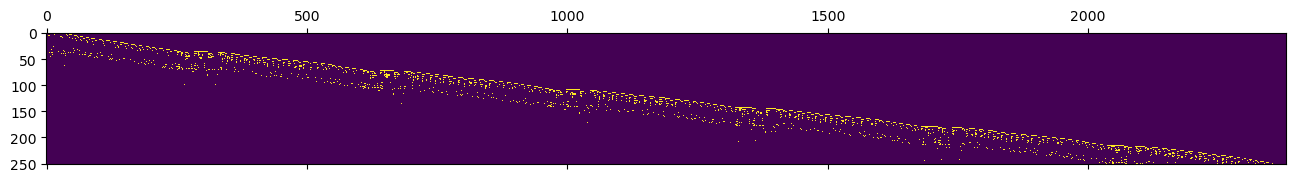

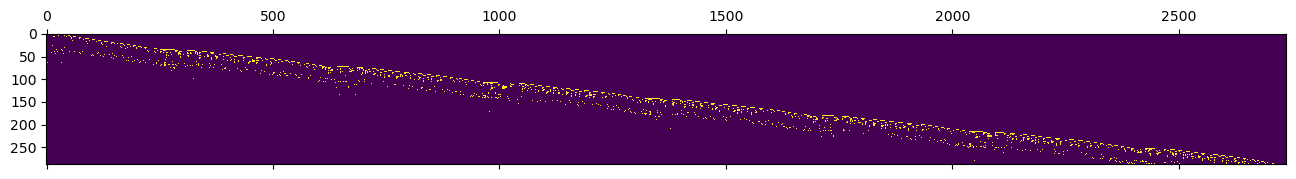

In [212]:
gen = 3
for ii in range(1+gen, 6+gen):
    s = Simulation(ii, 1)
    s.simulate()
    c = s.c

    sampler = c.compile_detector_sampler()
    dem = c.detector_error_model()
    pcm = lil_matrix((dem.num_detectors, dem.num_errors), dtype=np.bool_) # dem.num_detectors - corrected rounds, dem.num_errors - corrected errors
    lcm = lil_matrix((dem.num_observables, dem.num_errors), dtype=np.bool_)

    errors = []
    channel_probs = [e.args_copy()[0] for e in dem if e.type=="error"]
    for i, error_event in enumerate(c.explain_detector_error_model_errors()): # c.explain_detector_error_model_errors()[some indexing]
        dets = [det.dem_target.val for det in error_event.dem_error_terms if det.dem_target.is_relative_detector_id()]
        obs = [ob.dem_target.val for ob in error_event.dem_error_terms if ob.dem_target.is_logical_observable_id()]
        pcm[[dets],i] = 1
        lcm[[obs],i] = 1

    plt.matshow(pcm.A)
    print(pcm.shape, lcm.shape, max(pcm[gen*36:(gen+1)*36].nonzero()[1]))